## Motivation and Introduction

This is a reproduction work on the paper High-accuracy Decoding of Complex Visual Scenes from Neuronal Calcium Responses by Randall J. Ellis and Michael Michaelides.

In that paper, the authors used four models to decode neuronal calcium responses:
- SVM
- Shallow Neural Network (SNN)
- Deep Neural Network (DNN)
- Convolutional Neural Network (CNN).

The dataset is Allen Brain Observary (ABO). The classification task is to classify the 118 natural scene pictures (`natural_scenes` stimulus pattern).


## Data exploration

##### Manifest
We first print all the basic information for convenience.

In [1]:
from allensdk.core.brain_observatory_cache import BrainObservatoryCache
import pprint
import pandas as pd
import numpy as np
import pickle
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
# This class uses a 'manifest' to keep track of downloaded data and metadata.  
# All downloaded files will be stored relative to the directory holding the manifest
# file.  If 'manifest_file' is a relative path (as it is below), it will be 
# saved relative to your working directory.  It can also be an absolute path.
boc = BrainObservatoryCache(manifest_file='H:\\boc\\manifest.json')

# Download a list of all targeted areas
targeted_structures = boc.get_all_targeted_structures()
print("all targeted structures: " + str(targeted_structures), 'len = ', len(targeted_structures))
# Download a list of all imaging depths
depths = boc.get_all_imaging_depths()
print("all imaging depths: " + str(depths), 'len = ', len(depths))
# Download a list of all stimuli
stims = boc.get_all_stimuli()
print("all stimuli. len =", len(stims))
pprint.pprint(stims)
# Download a list of all cre driver lines
# Cre driver lines seemingly refer to different 
# phenotypic characterization of transgenic mouse lines
cre_lines = boc.get_all_cre_lines()
print("all cre lines len = ", len(cre_lines))
pprint.pprint(cre_lines)

all targeted structures: ['VISal', 'VISam', 'VISl', 'VISp', 'VISpm', 'VISrl'] len =  6
all imaging depths: [175, 185, 195, 200, 205, 225, 250, 265, 275, 276, 285, 300, 320, 325, 335, 350, 365, 375, 390, 400, 550, 570, 625] len =  23
all stimuli. len = 10
['drifting_gratings',
 'locally_sparse_noise',
 'locally_sparse_noise_4deg',
 'locally_sparse_noise_8deg',
 'natural_movie_one',
 'natural_movie_three',
 'natural_movie_two',
 'natural_scenes',
 'spontaneous',
 'static_gratings']
all cre lines len =  13
['Cux2-CreERT2',
 'Emx1-IRES-Cre',
 'Fezf2-CreER',
 'Nr5a1-Cre',
 'Ntsr1-Cre_GN220',
 'Pvalb-IRES-Cre',
 'Rbp4-Cre_KL100',
 'Rorb-IRES2-Cre',
 'Scnn1a-Tg3-Cre',
 'Slc17a7-IRES2-Cre',
 'Sst-IRES-Cre',
 'Tlx3-Cre_PL56',
 'Vip-IRES-Cre']


## Data Preparation (Feature selection)
> For each experimental condition (i.e., all experiments corresponding
> to a combination of neuron, region, and cortical depth), a three-dimensional array (Walt, Colbert,
>  and Varoquaux, 2011) was generated where **rows, columns, and ranks** corresponded to **scenes, neurons, and frames** respectively.

According to the origin paper, we use `dff_traces` as our featuzre. All the result are stored in xarray format here.

Due to main memory limitation, we will group data by region, dump eveything into files, and later read the concentrated data to reduce memory usage.

The following blocks only need to be run once on a new host.

In [5]:
import xarray as xr
def extrace_experimental_feature(exp_id, debug = False):
    exp = boc.get_ophys_experiment_data(exp_id)
    if debug:
        print(exp.get_metadata())
    # get data
    time, dff_traces = exp.get_dff_traces(cell_specimen_ids=None)
    # Get cell specimen
    exp_cell_ids = exp.get_cell_specimen_ids()
    if debug:
        print("cell num = ", len(exp_cell_ids))
        # check the corresponging of specimen and dff_trace
        check = True
        for id in exp.get_cell_specimen_ids():
            index = exp.get_cell_specimen_indices(cell_specimen_ids=[id])
            _, one_line = exp.get_dff_traces(cell_specimen_ids=[id])
            if not np.array_equal(dff_traces[index], one_line):
                print("check_failed")
                check = False
        if check:
            print("check success")
    # Get stimulus table
    stim_table = exp.get_stimulus_table('natural_scenes')
    labels = stim_table.frame.to_numpy()
    stim_table['prev_start'] = stim_table["start"].shift(1)
    stim_table['next_start'] = stim_table["start"].shift(-1)
    stim_table['next2_start'] = stim_table["start"].shift(-2)
    if debug:
        print(stim_table.head())
    index = 0
    # Since we need to do concat in neuron axis, we need to first sort them
    sorted_stim_table = stim_table.sort_values('frame')
    # prepare to deal with corner case, detect the first and last two frames 
    x = np.where(sorted_stim_table.isna())
    # TODO: judge which is first, which are last two
    sorted_stim_table = sorted_stim_table[sorted_stim_table['frame'] != -1]
    sorted_stim_table = sorted_stim_table.fillna(0)

    # Start to construct the final data
    total_sample = len(sorted_stim_table)  # 5900: 118 * 50
    # print(y[:10], y.shape)
    # Due to the data organization convenience, we change
    # coord order (scenes, neurons, frames) -> (neurons, scenes, frames)
    data = xr.DataArray(dims = ['scene', 'neuron', 'frame'], coords={
        'scene': range(0, total_sample),
        'neuron': exp.get_cell_specimen_ids(),
        'frame': range(28),
    })
    index = 0
    for _, lines in sorted_stim_table.iterrows():
        # print(lines)
        s0, s1, s2, s3 = lines['prev_start'], lines['start'], lines['next_start'], lines['next2_start']
        s0, s1, s2, s3 = int(s0), int(s1), int(s2), int(s3)
        frames = list(range(s0,s0+7)) + list(range(s1, s1+7)) + list(range(s2, s2+7)) + list(range(s3, s3+7))
        # print(frames)
        data[index] = dff_traces[:, frames]
        index += 1
        if debug:
            if (index % 1000 == 0): print(f"Sample {index} complete")
    data.data
    labels = sorted_stim_table.frame.to_numpy()
    # TODO: find the first one, and last two, since we need to recover those info
    return data, labels

all_experiments = boc.get_ophys_experiments()
all_experiments = pd.DataFrame(all_experiments)
# A simple SELECT function
def get_experiment_ids_by(targeted_structures = None, session_type = None):
    filtered_experiments = all_experiments
    if not targeted_structures is None:
        filtered_experiments = filtered_experiments[filtered_experiments['targeted_structure'] == targeted_structures]
    if not session_type is None:
        filtered_experiments = filtered_experiments[filtered_experiments['session_type'] == session_type]
    return filtered_experiments['id'].to_list() 


##### Step 1: Get all the experiments in each of the regions


In [ ]:
regions = ['VISp', 'VISal', 'VISl', 'VISpm', 'VISam', 'VISrl']

exp_ids = {}
max_exps_in_chunk = 40
for region in regions:
    exp_ids = get_experiment_ids_by(targeted_structures=region, session_type="three_session_B") # only session B has npy data file
    exp_count = len(exp_ids)
    
    print(f"Concatenate all experiment results in region {region}. Len = {exp_count}")
    num_chunks = (exp_count - 1)// max_exps_in_chunk + 1
    for chunkid in range(num_chunks):
        start_exp_idx = chunkid * max_exps_in_chunk
        end_exp_idx = (chunkid + 1) * max_exps_in_chunk
        if end_exp_idx > exp_count:
            end_exp_idx = exp_count
        exp_count_this_chunk = end_exp_idx - start_exp_idx
        if (start_exp_idx == end_exp_idx):
            continue
        print(f"\t Chunk ({chunkid}/{num_chunks}) [start, stop) = [{start_exp_idx}, {end_exp_idx}) ")
        total_data = None
        index = 1
        for id in exp_ids[start_exp_idx : end_exp_idx]:
            try:
                data, labels= extrace_experimental_feature(id)
            except:
                print(f"Error experiment id {id}")
                import traceback as tb
                tb.print_exc()
                continue
            if type(total_data) is type(None):
                total_data = data
            else:
                total_data = xr.concat([total_data, data], dim='neuron')
            if index % 10 == 1 or index == exp_count_this_chunk:
                print(f"Concat {index}/{exp_count_this_chunk}:")
                print("After concat: ", total_data.shape)
            index += 1
            del data, labels
        # to_netcdf("xxx.nc") will cause an OverflowError: Python int too large to convert to C long. Idk how to deal with it
        with open(f"dff_trace_{region}_{chunkid}_{num_chunks}.pkl", "wb") as f:
            pickle.dump(total_data, f, pickle.HIGHEST_PROTOCOL)
        del total_data

##### Step 2: Filter out high-response neurons.
> Visual decoding accuracy was measured in each population using only neurons with a high average response (ΔF/F > 0.01) across all 5900 scene presentations at any of the latter 21 frames, during the proximal scene and the two distal scenes. In each population, only neurons with a mean, ΔF/F response higher than 0.01 across all scene presentations within a single frame, from the beginning of the proximal scene to the end of the second distal scene, were used for training and validation. We refer to these neurons as high mean responders (HMRs).

In [ ]:

regions = ['VISp', 'VISal', 'VISl', 'VISpm', 'VISam', 'VISrl']
dir_files = os.listdir()
all_high_response_data = {}
for region in regions:
    pattern = r"dff_trace_" + region + r"_(\d+)_(\d+).pkl"
    filename_list = []
    for filename in dir_files:
        if re.match(pattern, filename) != None:
            filename_list.append(filename)
    print(region, filename_list)

    total_data = None
    index = 1
    for filename in filename_list:
        with open(filename, "rb") as f:
            data = pickle.load(f)
            mean_data = data.mean(axis=0)
            max_response = mean_data[:, 7:].max(axis=1)
            high_response_neuron = np.where(max_response > 0.01)[0]
            print(high_response_neuron)
            print(high_response_neuron.shape)
            high_response_data = data[:, high_response_neuron, :]

            if type(total_data) is type(None):
                total_data = high_response_data
            else:
                total_data = xr.concat([total_data, high_response_data], dim='neuron')
    all_high_response_data[region] = total_data

for region in regions:
    filename = f"dff_trace_high_response_{region}.pkl"
    with open(filename, "wb") as f:
        pickle.dump(all_high_response_data[region], f, protocol = 4) # protocol to deal with `cannot serialize a bytes object larger than 4 GiB` issue

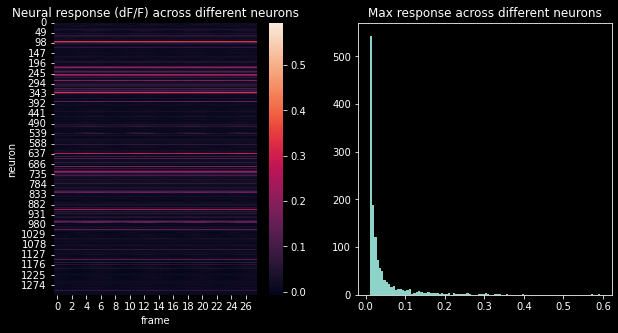

In [4]:
# Overview of the data within one region
regions = ['VISrl']
for region in regions:
    filename = f"dff_trace_high_response_{region}.pkl"
    with open(filename, "rb") as f:
        high_response_data = pickle.load(f) # protocol to deal with `cannot serialize a bytes object larger than 4 GiB` issue
    mean_data = high_response_data.mean(axis=0)
    max_response = mean_data[:, 7:].max(axis=1)
    f, (ax1, ax2) = plt.subplots(1,2,figsize=(10,5))

    p = sns.heatmap(mean_data, ax=ax1)
    p.set(title="Neural response (dF/F) across different neurons")
    p.set(xlabel = "frame")
    p.set(ylabel = "neuron")
    ax2.hist(max_response, bins=100)
    ax2.set_title("Max response across different neurons")

## Classification
- SVM
- SNN
- DNN
- CNN
  

We can organize the process into a function.

In [2]:
from sklearn.model_selection import train_test_split

labels = np.empty((118, 50))
labels[:] = np.arange(0, 118).reshape(-1, 1)
labels = labels.reshape(-1).astype(np.int32)
print(labels.shape, labels)

def generate_dataloader_from_file(filename):
    with open(filename, "rb") as f:
        data = pickle.load(f)

    print(data.shape, labels.shape)
    X = data.data
    X = X.reshape(X.shape[0], -1)
    y = labels
    # Split
    X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, X_test, y_train, y_test


(5900,) [  0   0   0 ... 117 117 117]


##### SVM

In [3]:
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC

def create_svm():
    model = OneVsRestClassifier(SVC(), n_jobs=10)
    return model

##### SNN
> A SNN (Fig. 1E) consisted of one batch normalization layer (Ioffe and Szegedy, 2015), a dropout
> layer (0.5) (Srivastava et al., 2014), a flattening layer, one dense layer with a rectified linear (relu)
> activation function and 400 nodes, a dropout layer (0.5), and a final dense layer with 118 nodes
> (for 118 classes) with a softmax activation function. An Adam optimizer was used for adjustment
> of learning rates (Kingma and Ba, 2014).



In [4]:
# My GPU has only 4G device memory, not enough for DNN. Disable GPU here
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1"

import tensorflow as tf
from tensorflow.keras import datasets, layers, models, callbacks
from tensorflow.keras.callbacks import CSVLogger

In [6]:
def create_snn():
    model = models.Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(400,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(118))
    model.add(layers.Softmax())
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

### DNN Model
> The DNN (Fig. 1F) consisted of one batch normalization
> layer, one hidden fully connected layer, dropout, another fully connected layer, another dropout,
> and a fully connected output layer. 

![](pic/nat-class-fig-1f.png)


In [7]:
def create_dnn():
    model = models.Sequential()
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Flatten())
    model.add(layers.Dense(400,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(400,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(118))
    model.add(layers.Softmax())
    model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
              metrics=['accuracy'])
    return model

##### CNN
> Finally, a CNN (Fig. 1G) was tested which consisted of one
> batch normalization layer, a 1D convolution, 1D MaxPooling, flattening, a dense layer (relu), dropout, and a final dense output layer.

![](nat-class-fig-1g.png)

In [8]:
def create_cnn():
    model = models.Sequential()
    model.add(layers.Reshape((-1, 28)))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Conv1D(32, 3)) # TODO: filter = ? kernel = ?
    model.add(layers.MaxPool1D())
    model.add(layers.Flatten())
    model.add(layers.Dense(400,activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(118))
    model.add(layers.Softmax())
    model.compile(optimizer='adam',
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
    return model

In [9]:

import os
model_dump_path = ".\\model"
try:
    os.mkdir(model_dump_path)
except FileExistsError:
    pass

_epoch = 20
def single_run(model, case_name, dataset, type="tf"):
    '''
    model: the model
    case_name: the case tag, and everything will be saved to .\\model\\{case_name}
    dataset: the data, X_train, X_test, y_train, y_test
    type: 'sklearn': SVM, 'tf': SNN/DNN/CNN
    '''
    model_dump_fullpath = os.path.join(model_dump_path, case_name)
    print(model_dump_fullpath)
    try:
        os.mkdir(model_dump_fullpath)
    except FileExistsError:
        pass
    # read data file
    X_train, X_test, y_train, y_test = dataset
    print("Training size:", X_train.shape, y_train.shape)
    print("Test size:", X_test.shape, y_test.shape)

    if type == "tf":
        # save history
        csv_logger = CSVLogger(os.path.join(model_dump_fullpath, 'training.log'))
        history = model.fit(X_train, y_train, epochs=_epoch,
                        validation_data=(X_test, y_test), callbacks=[csv_logger])
        # history_dump_file = os.path.join(model_dump_fullpath, "history.csv")
        # df_history = pd.DataFrame(history.history)
        # df_history.to_csv(history_dump_file)
        # save model
        model.save(model_dump_fullpath)
    elif type == "sklearn":
        model.fit(X_train, y_train)
        pred_acc = model.score(X_test, y_test)
        with open(os.path.join(model_dump_fullpath, "score.log"), "w") as f: 
            f.write(f"{pred_acc}" + "\n")

In [11]:
dataname_list = [
    # "high_response_VISal",
    "high_response_VISam",
    "high_response_VISl",
    "high_response_VISp",
    "high_response_VISpm",
    "high_response_VISrl"
]

for dataname in dataname_list:
    data_filename = f"dff_trace_{dataname}.pkl"
    X_train, X_test, y_train, y_test = generate_dataloader_from_file(data_filename)
    dataset = X_train, X_test, y_train, y_test

    # try each model
    # Too slow, skipped
    # model_name = dataname + "_SVM"
    # model = create_svm()
    # single_run(model, model_name, dataset, type="sklearn")

    model_name = dataname + "_SNN"
    model = create_snn()
    single_run(model, model_name, dataset, type="tf")

    model_name = dataname + "_DNN"
    model = create_dnn()
    single_run(model, model_name, dataset, type="tf")

    model_name = dataname + "_CNN"
    model = create_dnn()
    single_run(model, model_name, dataset, type="tf")


(5900, 794, 28) (5900,)
.\model\high_response_VISam_SNN
Training size: (4720, 22232) (4720,)
Test size: (1180, 22232) (1180,)
Epoch 1/20
148/148 [==============================] - 10s 61ms/step - loss: 7.5941 - accuracy: 0.0680 - val_loss: 4.3556 - val_accuracy: 0.1195
Epoch 2/20
148/148 [==============================] - 9s 58ms/step - loss: 1.6968 - accuracy: 0.6121 - val_loss: 4.0728 - val_accuracy: 0.1619
Epoch 3/20
148/148 [==============================] - 8s 53ms/step - loss: 0.8885 - accuracy: 0.7729 - val_loss: 4.0321 - val_accuracy: 0.2432
Epoch 4/20
148/148 [==============================] - 8s 52ms/step - loss: 0.5340 - accuracy: 0.8557 - val_loss: 4.0922 - val_accuracy: 0.2661
Epoch 5/20
148/148 [==============================] - 8s 54ms/step - loss: 0.4567 - accuracy: 0.8833 - val_loss: 4.2516 - val_accuracy: 0.2898
Epoch 6/20
148/148 [==============================] - 8s 53ms/step - loss: 0.3811 - accuracy: 0.8989 - val_loss: 4.4731 - val_accuracy: 0.2780
Epoch 7/20
148/

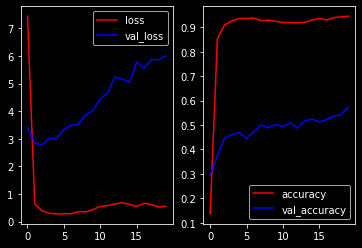

In [12]:
import matplotlib.pyplot as plt
# model.summary()
df_history = pd.read_csv("./model/high_response_VISpm_SNN/training.log")
df_history.head()
ax = plt.subplot(1,2,1)
ax.plot(df_history['loss'], color="red")
ax.plot(df_history['val_loss'], color="blue")
ax.legend(['loss', 'val_loss'])
ax2 = plt.subplot(1,2,2)
ax2.plot(df_history['accuracy'], color="red")
ax2.plot(df_history['val_accuracy'], color="blue")
ax2.legend(['accuracy', 'val_accuracy'])


In [ ]:
# I found that DNN and CNN model's performacace are far from satisfaction, exploring them a little bit
# model = models.Sequential()
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
# model.add(layers.Flatten())
# model.add(layers.Dense(400,activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(400,activation='relu'))
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(118))
# model.add(layers.Softmax())
# model.compile(optimizer='adam',
#             loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#             metrics=['accuracy'])
# X_test_small = X_test[:10]
# y_test_small = y_test[:10]
# y_pred = model.predict(X_test_small)
# print(y_pred.shape)
# print(y_pred.max(axis = 1))
# print(y_pred.argmax(axis = 1))
# print(y_test_small)
# sns.heatmap(y_pred)
